In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mental-health-and-social-media-balance-dataset/Mental_Health_and_Social_Media_Balance_Dataset.csv


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("prince7489/mental-health-and-social-media-balance-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/mental-health-and-social-media-balance-dataset


In [6]:
import pandas as pd
import os

In [9]:
os.listdir(path)

['Mental_Health_and_Social_Media_Balance_Dataset.csv']

In [10]:
df = pd.read_csv(os.path.join(path,"Mental_Health_and_Social_Media_Balance_Dataset.csv"))
df.head()

,User_ID,Age,Gender,Daily_Screen_Time(hrs),Sleep_Quality(1-10),Stress_Level(1-10),Days_Without_Social_Media,Exercise_Frequency(week),Social_Media_Platform,Happiness_Index(1-10)
0,U001,44,Male,3.1,7.0,6.0,2.0,5.0,Facebook,10.0
1,U002,30,Other,5.1,7.0,8.0,5.0,3.0,LinkedIn,10.0
2,U003,23,Other,7.4,6.0,7.0,1.0,3.0,YouTube,6.0
3,U004,36,Female,5.7,7.0,8.0,1.0,1.0,TikTok,8.0
4,U005,34,Female,7.0,4.0,7.0,5.0,1.0,X (Twitter),8.0


## Research Question

Does taking breaks from social media reduce anxiety?

### Hypothesis
People who regularly take more breaks from social media report lower levels of stress than people who take less breaks from social media.

In [14]:
df['Days_Without_Social_Media'].describe()

count    500.000000
mean       3.134000
std        1.858751
min        0.000000
25%        2.000000
50%        3.000000
75%        5.000000
max        9.000000
Name: Days_Without_Social_Media, dtype: float64

#
Because the maximum is 9, we can assume that the subjects in this data set likely were asked a question like "in the past x days, how many days did you break from social media usage." 

In [29]:
df["Takes_Breaks"] = df["Days_Without_Social_Media"] > 0

In [32]:
df.groupby("Takes_Breaks")["Stress_Level(1-10)"].mean()

Takes_Breaks
False    6.750000
True     6.603982
Name: Stress_Level(1-10), dtype: float64

<Axes: xlabel='Takes_Breaks'>

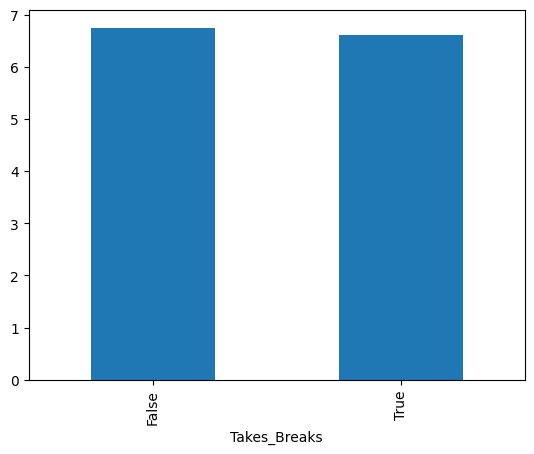

In [33]:
df.groupby("Takes_Breaks")["Stress_Level(1-10)"].mean().plot(kind="bar")

The group that takes breaks reports an average stress level of approximately 6.60, while the group that does not take breaks reports an average stress level of approximately 6.75. This suggests that breaks help with stress level a bit.

Because the average stress level is so similar, I think it would be best to investigate the difference between few breaks and many breaks.

<Axes: ylabel='Frequency'>

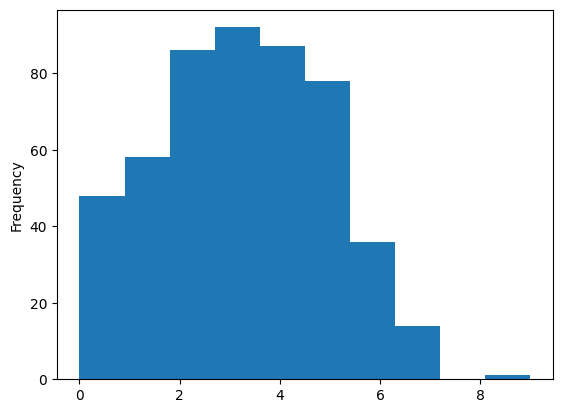

In [35]:
df["Days_Without_Social_Media"].plot(kind='hist')

The average amount of breaks taken is around 3, with 9 seemingly being an outlier.

In [43]:
df["Under_3_Breaks"] = df["Days_Without_Social_Media"] < 3

In [44]:
df.groupby("Under_3_Breaks")["Stress_Level(1-10)"].mean()

Under_3_Breaks
False    6.584416
True     6.671875
Name: Stress_Level(1-10), dtype: float64

<Axes: xlabel='Under_3_Breaks'>

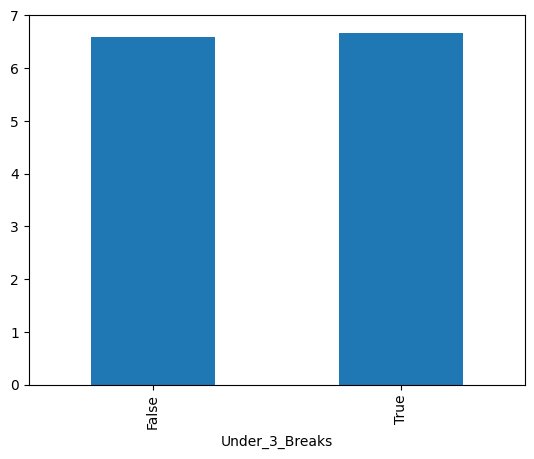

In [45]:
df.groupby("Under_3_Breaks")["Stress_Level(1-10)"].mean().plot(kind="bar")

The group with under 3 breaks reports an average stress level of 6.67, while the group who takes 3 or more breaks reports an average stress level of 6.58. This shows that stress levels for those who take more breaks is slightly lower than those who take less breaks.

At this point, our data from both comparisons (0 breaks vs breaks and under 3 breaks vs 3 or more breaks) shows that those who take breaks have average stress levels that are slightly less than those who take less breaks or no breaks.

From here, we will move forward by using a t-test to see if the difference in means is significant. I will start with the 'No breaks vs breaks' averages of 6.75 and 6.60 respectively.

For this first t-test, our null hypothesis is that there is no difference in average stress level between people who take breaks and people who don't take breaks. Our alternative hypothesis is that people who take breaks have a different average stress level when compared to people who don't take breaks.   

In order to use a t-test, we must make sure the assumptions of the t-test are met. Each row of our dataset represents a different individual; There are no repeated measures from the same person. Therefore, the independence assumption is reasonably satisfied.

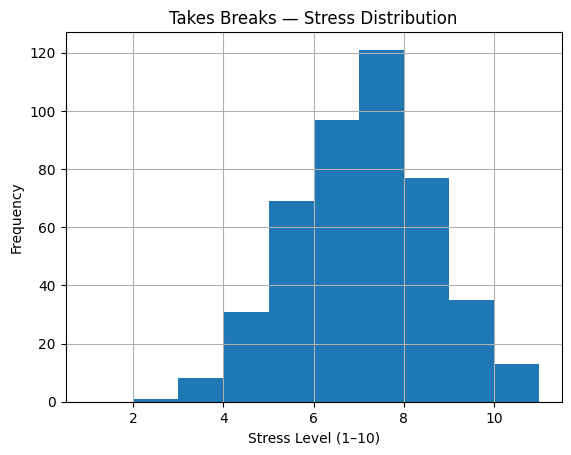

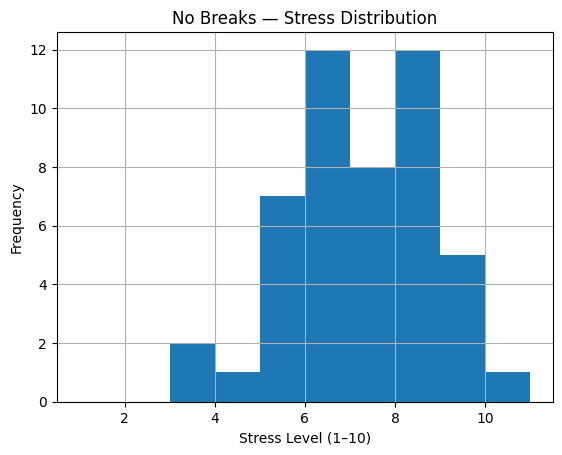

In [57]:
import matplotlib.pyplot as plt

bins = range(1, 12)   # 1 through 10 inclusive

df[df["Takes_Breaks"] == True]["Stress_Level(1-10)"].hist(bins=bins)
plt.title("Takes Breaks — Stress Distribution")
plt.xlabel("Stress Level (1–10)")
plt.ylabel("Frequency")
plt.show()

df[df["Takes_Breaks"] == False]["Stress_Level(1-10)"].hist(bins=bins)
plt.title("No Breaks — Stress Distribution")
plt.xlabel("Stress Level (1–10)")
plt.ylabel("Frequency")
plt.show()

The distributions of those who take breaks and those who don't take breaks both appear approximately normal, with no heavy tails or extreme skew. Thus, the normality assumption is reasonably satisfied. Moreover, each group has a large sample size, so the Central Limit Theorem supports using a t-test.

In [58]:
from scipy.stats import levene

levene_stat, levene_p = levene(break_group, no_breaks_group)
levene_p

0.6362832606942974

Finally, the Levene’s test for equality of variances produced a p-value of 0.636, which is significantly higher than 0.05. Therefore, there is no evidence of unequal variances so equal varriance assumption is met.

Now, we can proceed with the t-test because all of the assumptions are met.

In [51]:
from scipy.stats import ttest_ind

break_group = df[df["Takes_Breaks"] == True]["Stress_Level(1-10)"]

no_breaks_group = df[df["Takes_Breaks"] == False]["Stress_Level(1-10)"]

t_stat,p_value = ttest_ind(break_group, no_breaks_group)
t_stat,p_value

(-0.62298703167437, 0.5335782273469254)

Because our p-value of approximately 0.533 is not lower than 0.05, there is no statistically significant difference in average stress level between those who took breaks and those who did not take breaks. In other words, we can not reject the null. 

Next, we will run a t-test comparing the mean stress level of those who took less than 3 breaks and those who took 3 or more breaks.

For this t-test, our null hypotheis is that there is no difference in average stress level between people who take less than 3 breaks and people who take 3 or more breaks. The alternative hypothesis is that there is a difference in average stress level between people who take less than 3 breaks and people who take 3 or more breaks.

Again, we must check the assumptions for this t-test. Same as in the prior test, the independance assumption is met because there is one observation per participant and no repeated measures.


1)independence of observations
2)normality in groups
3)equal variance

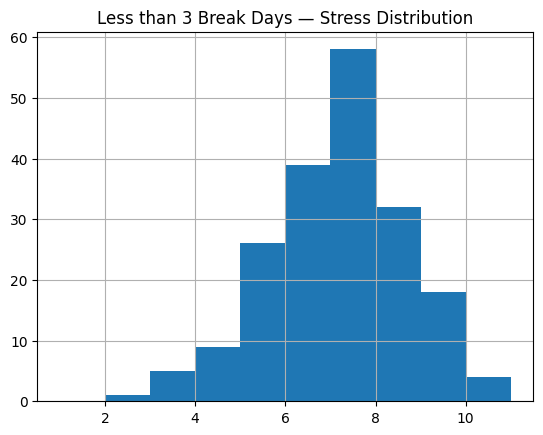

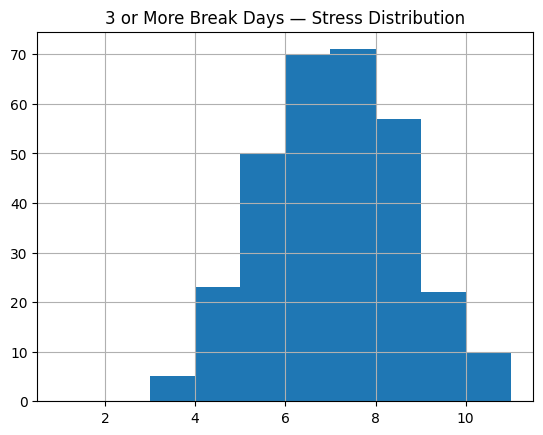

In [59]:
import matplotlib.pyplot as plt

bins = range(1,12)

df[df["Under_3_Breaks"] == True]["Stress_Level(1-10)"].hist(bins=bins)
plt.title("Less than 3 Break Days — Stress Distribution")
plt.show()

df[df["Under_3_Breaks"] == False]["Stress_Level(1-10)"].hist(bins=bins)
plt.title("3 or More Break Days — Stress Distribution")
plt.show()

Subsequently, the normality assumption is reasonably met because both distributions above are normal, with no strong skew or heavy tails. Again, because each group has a large sample size, the Central Limit Theorem supports our efforts.

In [60]:
from scipy.stats import levene

under_3_break_group = df[df["Under_3_Breaks"] == True]["Stress_Level(1-10)"]

three_or_more_break_group = df[df["Under_3_Breaks"] == False]["Stress_Level(1-10)"]

levene_stat, levene_p = levene(under_3_break_group, three_or_more_break_group)
levene_p

0.2598584385556506

Because the Levene p-value of 0.259 is larger than 0.05, the equal variance assumption is reasonably satisfied. 

All of the assumptions for the t-test are met, so we can proceed.

In [52]:
from scipy.stats import ttest_ind

t_stat,p_value = ttest_ind(under_3_break_group, three_or_more_break_group)
t_stat,p_value

(0.6160450402950716, 0.5381462605323187)

For this second t-test, because our p-value of approximately 0.538 greater than 0.05, there is no statistically significant difference in average stress level between those who took less than three breaks and those who took three or more breaks. Thus, we fail to reject the null hypothesis again.

## Conclusion

Approaching this project, I expected that the average stress level of people who took more breaks would be less than the average stress level of people who took less or no breaks. According to this dataset, there is no strong evidence that taking breaks correlates with lower stress levels.

One limitation of this analysis is that stress level is affected by other variables, not just break taking. Daily screentime outside of breaks and how a user uses screens are two other variables that could heavily influence stress level.

Moving forward, it could be very interesting to anazlyze a multi-variable model. This type of model might better capture how other variables influence stress level in addition to the amount of breaks.